In [6]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell
from deepcell.applications import MultiplexSegmentation

In [4]:
# load data
#data_dir = '/data/patricia/20200320_Test_Run/'
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
data_dir = '/data/segmentation/20200429_cHL/'
data_dir = '/data/reema/20200422_test/'

In [5]:
cohort_xr = xr.open_dataarray(data_dir + 'deepcell_input.xr')
cohort_xr.shape

(6, 1024, 1024, 2)

In [9]:
vals = np.roll(cohort_xr.values, axis=3, shift=1)

In [7]:
app = MultiplexSegmentation()

W0508 17:10:03.323793 139814067160896 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
# whole-cell
weights = "/data/models/20200227_IF_Training/20200315_IF_Training_6_deep_watershed_updated.h5"

# mibi
#weights = "/data/models/20200227_IF_Training/20200506_MIBI_combined_deep_watershed.h5"

In [34]:
app.model.load_weights(weights)

In [35]:
resized_input = app._resize_input(vals, image_mpp=2)
inner_distance, outer_distance, fgbg, pixelwise = test_images = app._run_model(resized_input)

In [36]:
combined = np.concatenate((pixelwise[:, :, :, 1:2], pixelwise[:, :, :, 0:1], 
                           inner_distance, outer_distance, fgbg[:, :, :, 1:2]), axis=-1)
combined.shape

(6, 1024, 1024, 5)

In [37]:
from deepcell_toolbox.utils import resize
original_shape = cohort_xr.shape[1:3]
reversed_shape = original_shape[::-1]
resized_output = resize(combined, reversed_shape)

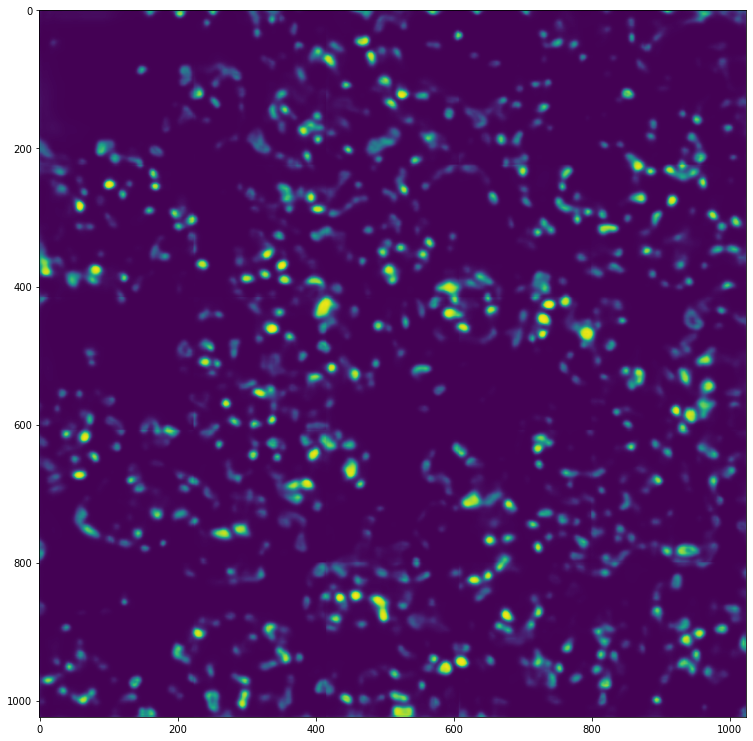

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(resized_output[4, :, :, 0])

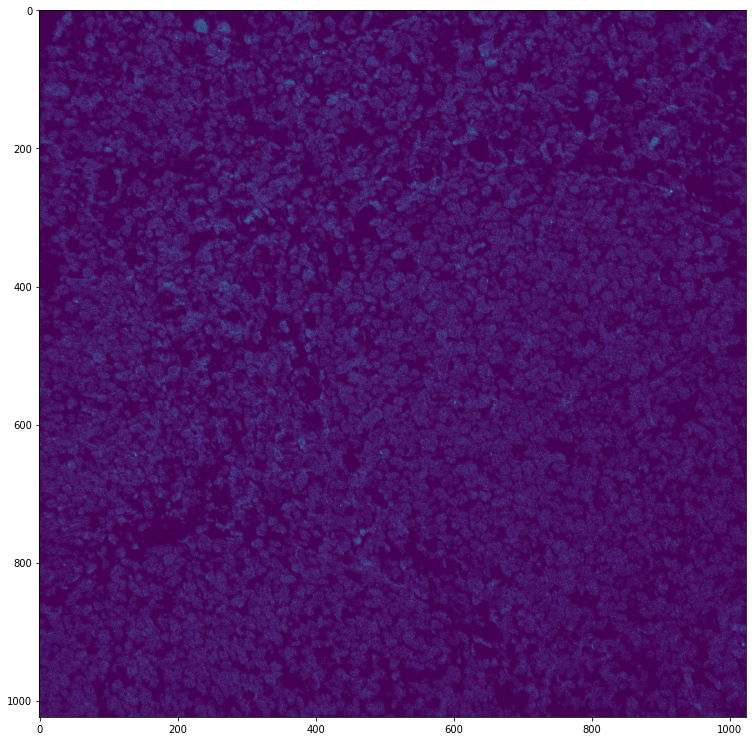

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(vals[2, :, :, 0])

In [15]:
model_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'pixelwise_border', 'watershed_inner', 
                                  'watershed_outer', 'fgbg_foreground', 'pixelwise_sum']],
                         dims=['fovs', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF3_64BIT")